# SageMaker Random Cut Forests - Anomoly Detection

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***


# Introduction
***

Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. 

Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are.

<hr>
<hr>
<hr>
# Act 1: Investigating the data.  

## Step thrugh these steps up until Act 2

### Examine the results as we run through it.

## IMPORTANT: FILL IN THE BUCKET BELOW

In [25]:
bucket = 'FILL_IN_HERE'   # <--- specify a bucket you created in lab1
prefix = 'sagemaker/rcf-benchmarks'

trainingInstanceType = 'ml.m4.xlarge'
inferenceInstanceType = 'ml.m4.xlarge'
trainingInstanceCount = 1

In [26]:
import boto3
import botocore
import sagemaker
import sys

execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('ERROR - You either forgot to specify your S3 bucket or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("ERROR - You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("ERROR - Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://snively-sagemaker/sagemaker/rcf-benchmarks


              timestamp  value
0   2014-07-01 00:00:00  10844
1   2014-07-01 00:30:00   8127
2   2014-07-01 01:00:00   6210
3   2014-07-01 01:30:00   4656
4   2014-07-01 02:00:00   3820
5   2014-07-01 02:30:00   2873
6   2014-07-01 03:00:00   2369
7   2014-07-01 03:30:00   2064
8   2014-07-01 04:00:00   2221
9   2014-07-01 04:30:00   2158
10  2014-07-01 05:00:00   2515
11  2014-07-01 05:30:00   4364
12  2014-07-01 06:00:00   6526
13  2014-07-01 06:30:00  11039
14  2014-07-01 07:00:00  13857
15  2014-07-01 07:30:00  15865
16  2014-07-01 08:00:00  17920
17  2014-07-01 08:30:00  20346
18  2014-07-01 09:00:00  19539
19  2014-07-01 09:30:00  20107
CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 139 ms


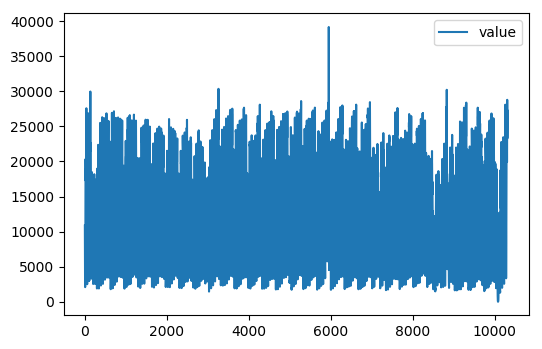

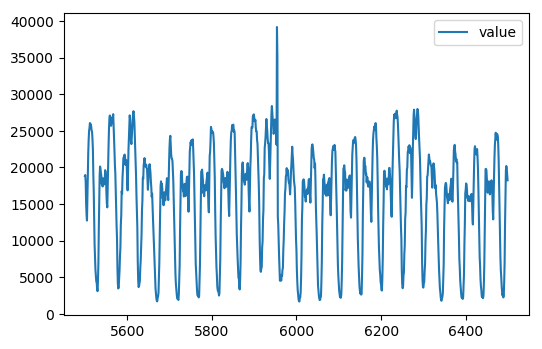

In [27]:
%%time

import pandas as pd
import urllib.request

data_filename = 'nyc_taxi.csv'
data_source = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

urllib.request.urlretrieve(data_source, data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=',')

print(taxi_data.head(20))

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

taxi_data.plot()

taxi_data[5500:6500].plot()

In [28]:
print(taxi_data[5952:6000])

                timestamp  value
5952  2014-11-02 00:00:00  25110
5953  2014-11-02 00:30:00  23109
5954  2014-11-02 01:00:00  39197
5955  2014-11-02 01:30:00  35212
5956  2014-11-02 02:00:00  13259
5957  2014-11-02 02:30:00  12250
5958  2014-11-02 03:00:00  10013
5959  2014-11-02 03:30:00   7898
5960  2014-11-02 04:00:00   6375
5961  2014-11-02 04:30:00   4532
5962  2014-11-02 05:00:00   5116
5963  2014-11-02 05:30:00   5232
5964  2014-11-02 06:00:00   4542
5965  2014-11-02 06:30:00   5298
5966  2014-11-02 07:00:00   5155
5967  2014-11-02 07:30:00   6029
5968  2014-11-02 08:00:00   6280
5969  2014-11-02 08:30:00   8771
5970  2014-11-02 09:00:00  10151
5971  2014-11-02 09:30:00  12501
5972  2014-11-02 10:00:00  13990
5973  2014-11-02 10:30:00  16534
5974  2014-11-02 11:00:00  17133
5975  2014-11-02 11:30:00  18775
5976  2014-11-02 12:00:00  18985
5977  2014-11-02 12:30:00  19911
5978  2014-11-02 13:00:00  19123
5979  2014-11-02 13:30:00  19524
5980  2014-11-02 14:00:00  19640
5981  2014

<hr>
<hr>
<hr>
# ACT 2 -- let's train a model.  
## this part trains an initial model

Examine the code as we run it.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In [29]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=trainingInstanceCount,
                      train_instance_type=trainingInstanceType,
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.as_matrix().reshape(-1,1)))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-08-26-00-48-53-413


........................
Docker entrypoint called with argument(s): train
[08/26/2018 00:52:47 INFO 139915372554048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[08/26/2018 00:52:47 INFO 139915372554048] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'1', u'num_samples_per_tree': u'512', u'num_trees': u'50'}
[08/26/2018 00:52:47 INFO 139915372554048] Final configuration: {u'num_samples_per_tree': u'512', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'tru


Billable seconds: 126


Wait until the cell finishes running,  it often times between 4-8 minutes.

In [30]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2018-08-26-00-48-53-413


<hr>
<hr>
<hr>
# Act 3: Inferencing (evaluating our model)

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [31]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type=inferenceInstanceType,
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-08-26-00-53-36-043
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-08-26-00-48-53-413


--------------------------------------------------------------------------!

In [32]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2018-08-26-00-48-53-413


#### Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [33]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [34]:
taxi_data_numpy = taxi_data.value.as_matrix().reshape(-1,1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(taxi_data_numpy[:6])

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


####  Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [35]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
taxi_data['score'] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.974920
1,2014-07-01 00:30:00,8127,1.007771
2,2014-07-01 01:00:00,6210,0.990810
3,2014-07-01 01:30:00,4656,0.874161
4,2014-07-01 02:00:00,3820,0.864845


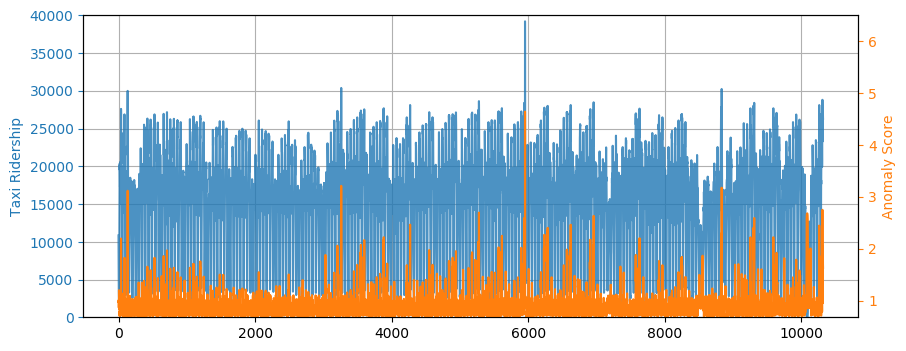

In [36]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
#start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset['value'], color='C0', alpha=0.8)
ax2.plot(taxi_data_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [37]:
score_mean = taxi_data['score'].mean()
score_std = taxi_data['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = taxi_data_subset[taxi_data_subset['score'] > score_cutoff]
print(anomalies)

                 timestamp  value     score
37     2014-07-01 18:30:00  27598  2.195821
38     2014-07-01 19:00:00  26827  1.785644
87     2014-07-02 19:30:00  26872  1.825300
134    2014-07-03 19:00:00  29985  3.115458
423    2014-07-09 19:30:00  26319  1.654173
527    2014-07-11 23:30:00  26873  1.825927
661    2014-07-14 18:30:00  26945  1.858769
709    2014-07-15 18:30:00  26340  1.647128
710    2014-07-15 19:00:00  27167  1.966323
1094   2014-07-23 19:00:00  26528  1.698557
1098   2014-07-23 21:00:00  26600  1.709028
1198   2014-07-25 23:00:00  26688  1.756191
1200   2014-07-26 00:00:00  26300  1.640056
3031   2014-09-02 03:30:00   1431  1.880111
3206   2014-09-05 19:00:00  27337  2.057932
3207   2014-09-05 19:30:00  26812  1.774766
3208   2014-09-05 20:00:00  26592  1.704820
3212   2014-09-05 22:00:00  26603  1.706883
3213   2014-09-05 22:30:00  26899  1.833001
3214   2014-09-05 23:00:00  26900  1.833470
3215   2014-09-05 23:30:00  26763  1.757536
3261   2014-09-06 22:30:00  3031

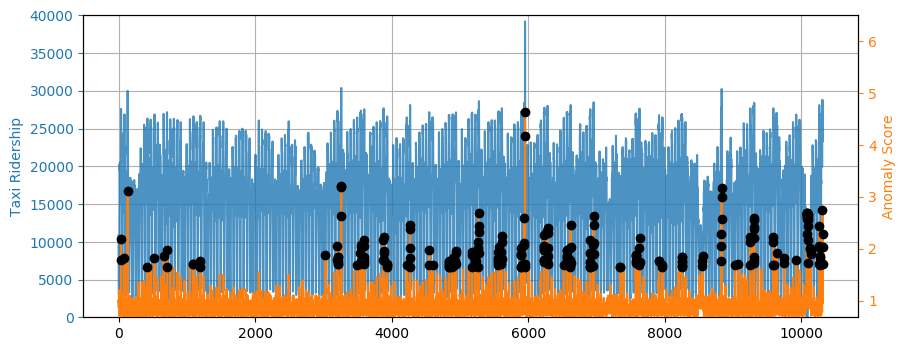

In [38]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

In [39]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-08-26-00-48-53-413


# ACT 3 -- Getting better results.

### Another improvement is make use of a windowing technique called "shingling". 
This is especially useful when working with periodic data with known period, such as the NYC taxi dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [40]:
import numpy as np

def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = prefix + '_shingled'
taxi_data_shingled = shingle(taxi_data.values[:,1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [41]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=trainingInstanceCount,
                      train_instance_type=trainingInstanceType,
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-08-26-00-59-53-537


.........................
Docker entrypoint called with argument(s): train
[08/26/2018 01:03:53 INFO 139979060979520] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[08/26/2018 01:03:53 INFO 139979060979520] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'48', u'num_samples_per_tree': u'512', u'num_trees': u'50'}
[08/26/2018 01:03:53 INFO 139979060979520] Final configuration: {u'num_samples_per_tree': u'512', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u't


Billable seconds: 129


In [42]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type=inferenceInstanceType,
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

INFO:sagemaker:Creating model with name: randomcutforest-2018-08-26-01-04-36-142
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-08-26-00-59-53-537


---------------------------------------------------------------!

Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [43]:
# Score the shingled datapoints
results = rcf_inference.predict(taxi_data_shingled)
scores = np.array([datum['score'] for datum in results['scores']])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3*score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.46187827 1.48069633 1.48058632 1.48848174 1.48186666 1.52110039
 1.59057004 1.60308624 1.639184   1.59748864 1.6200432  1.59160103
 1.51687667 1.53905332 1.58352308 1.54325324 1.58746568 1.59635032
 1.62508639 1.66152648 1.69538316 1.63971749 1.6522051  1.70639858
 1.60540987 1.58064871 1.51591893 1.53518188 1.5425206  1.50535695
 1.54856423 1.51643034 1.48873621 1.46064081 1.49718818 1.5043791
 1.42726657 1.44192705 1.45178376 1.46908325 1.4824579  1.50273991
 1.53592038 1.52660967 1.49627977 1.51295474 1.50760492 1.54983208
 1.55852895 1.44579237 1.48479081 1.45516146 1.49009688 1.50054002
 1.56363132 1.57499822 1.5754131  1.50580027 1.49710164 1.43360107
 1.42931243 1.43300983 1.43641846 1.47932797 1.43640883 1.47239175
 1.50997753 1.52875944 1.55932087 1.60325343 1.61004471 1.64074008
 1.66492062 1.70575405 1.72071543 1.79515601 1.77299857 1.81211747
 1.81774867 1.87373779 1.90589595 1.96889217 2.01335367 2.0274736
 2.0468995  2.10339907 2.12264205 2.16566262 2.17562052 2.136683

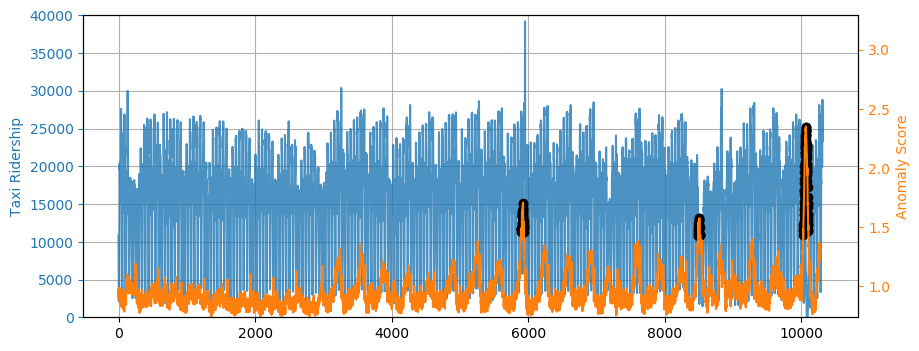

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data['value'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [45]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-08-26-00-59-53-537
